# Fit a GAP Potential
Explore how we can fit a [GAP](https://arxiv.org/pdf/1502.01366.pdf) potential using scikit-learn

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mcdemo.lfa.gap.skl import SOAPConverter, ScalableKernel, ScaleFeatures
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn import metrics
from dscribe.descriptors import SOAP
from functools import partial
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os

## Load in the Dataset
Get the dataset form the previous example

In [2]:
data = pd.read_pickle('atoms.pkl.gz')
print(f'Loaded {len(data)} training examples')

Loaded 256 training examples


Make a train-test split

In [3]:
train_data, test_data = train_test_split(data, train_size=0.9, shuffle=True)

## Make the Model
Use a Pipeline to do the kernel calculations

In [4]:
model = Pipeline([
    ('soap', SOAPConverter()),
    ('scaler', ScaleFeatures()),
    ('kernel', ScalableKernel()),
    ('model', BayesianRidge())
])

In [5]:
model

Pipeline(memory=None,
         steps=[('soap',
                 SOAPConverter(lmax=None, nmax=None, rcut=None, species=None)),
                ('scaler', ScaleFeatures(eps=1e-06)),
                ('kernel', ScalableKernel(gamma=1.0, max_points=None)),
                ('model',
                 BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                               compute_score=False, copy_X=True,
                               fit_intercept=True, lambda_1=1e-06,
                               lambda_2=1e-06, n_iter=300, normalize=False,
                               tol=0.001, verbose=False))],
         verbose=False)

## Test Model
Use a 50/50 train/test split

In [6]:
results = []
for y in tqdm(np.logspace(-2, 2, 8)):
    model.set_params(kernel__gamma=y)
    model.fit(train_data['atoms'], train_data['energy'])
    y_pred = model.predict(test_data['atoms'])
    results.append({
        'gamma': y,
        'mae': metrics.mean_absolute_error(y_pred, test_data['energy'])
    })

100%|██████████| 8/8 [04:40<00:00, 35.04s/it]


Plot the outputs

In [7]:
results = pd.DataFrame(results)

Text(0, 0.5, 'MAE (Ha)')

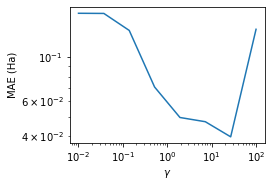

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))
ax.loglog(results['gamma'], results['mae'])
ax.set_xlabel('$\gamma$')
ax.set_ylabel('MAE (Ha)')

Pick the best model

In [9]:
model.set_params(kernel__gamma=results.loc[results['mae'].idxmin()]['gamma'])
model.fit(train_data['atoms'], train_data['energy'])

Pipeline(memory=None,
         steps=[('soap',
                 SOAPConverter(lmax=None, nmax=None, rcut=None, species=None)),
                ('scaler', ScaleFeatures(eps=1e-06)),
                ('kernel',
                 ScalableKernel(gamma=26.826957952797247, max_points=None)),
                ('model',
                 BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                               compute_score=False, copy_X=True,
                               fit_intercept=True, lambda_1=1e-06,
                               lambda_2=1e-06, n_iter=300, normalize=False,
                               tol=0.001, verbose=False))],
         verbose=False)

In [10]:
%%time
pred_y, pred_std = model.predict(test_data['atoms'], return_std=True)
print(f'MAE: {(pred_y - test_data["energy"]).abs().mean()} Ha')

MAE: 0.03971662929941972 Ha
CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 3.13 s


Text(0, 0.5, '$\\Delta E$, ML (Ha)')

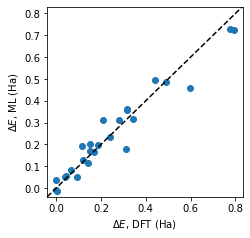

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))


ax.scatter(test_data['energy'] - test_data['energy'].min(), pred_y - test_data['energy'].min())

lims = ax.get_xlim()
#lims[0] = 0
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')

ax.set_xlabel('$\Delta E$, DFT (Ha)')
ax.set_ylabel('$\Delta E$, ML (Ha)')